# Task 01: Selecting earthquakes
* Earthquake events downloaded from the USGS earthquake catalog (https://earthquake.usgs.gov/earthquakes/search/) for the study area (-123 to -128 degrees West and 37.5 to 41.5 degrees North), from January 1, 1970 to September 1, 2023 and magnitude 2.0 and above. 
* Subduction interface (between undergoing Juan de Fuca/Gorda plate and overriding North American plate) data called `slab2` is downloded from https://www.sciencebase.gov/catalog/item/5aa312cde4b0b1c392ea3ef5 
* The following codes will select earthquakes that are avobe the interface (i.e., earthquake depth < interface depth) and earthquakes that are within the area covered by the slab2 data (slab2 data is for limited area).
* It will also select earthquakes after January 1, 2008 to Jan 01, 2023

# Part 1: Data selection and preparation

In [26]:
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# read in the original earthquake data from USGS
eq_df = pd.read_csv('../data/new_area_all_query-1970_20230901_2-10.csv',
                    parse_dates=['time']

                    )
# select earthquakes from Jan 1, 2008 to Jan 1, 2023
eq_df = eq_df[(eq_df['time'] > '2008-01-01') & (eq_df['time'] < '2023-01-01')]

# reset the index
eq_df.reset_index()

eq_df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
6582,2008-01-14 19:11:31.050000+00:00,40.779833,-123.564000,22.509,2.50,md,16.0,105.0,0.1595,0.17,...,2017-01-17 17:24:51.218000+00:00,"8 km WSW of Burnt Ranch, California",earthquake,0.52,0.92,0.120,19.0,reviewed,nc,nc
6583,2008-01-24 05:22:21.820000+00:00,40.317167,-125.849000,31.622,3.12,md,26.0,312.0,1.1640,0.34,...,2017-01-17 18:39:28.805000+00:00,"137 km WSW of Ferndale, California",earthquake,4.23,31.61,0.126,7.0,reviewed,nc,nc
6584,2008-02-10 06:04:43.980000+00:00,40.385833,-124.996333,0.530,2.65,md,39.0,259.0,0.5108,0.15,...,2017-01-17 20:35:23.984000+00:00,"65 km WSW of Ferndale, California",earthquake,1.10,2.08,0.083,8.0,reviewed,nc,nc
6585,2008-02-22 10:37:52.230000+00:00,40.614833,-125.506333,25.612,3.17,ml,32.0,292.0,0.9009,0.17,...,2017-01-17 22:00:42.477000+00:00,"105 km W of Ferndale, California",earthquake,4.73,13.37,0.179,7.0,reviewed,nc,nc
6586,2008-02-23 09:23:47.640000+00:00,41.188000,-127.347000,5.000,3.50,md,10.0,277.0,NaN,NaN,...,2017-01-17 22:08:48.136000+00:00,"268 km W of Indianola, California",earthquake,NaN,NaN,NaN,NaN,reviewed,nc,nc


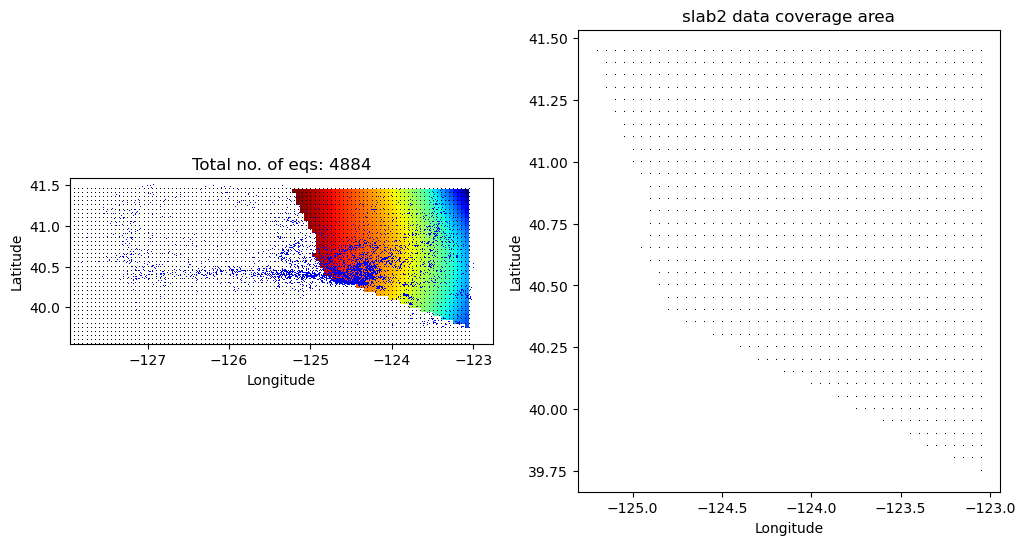

In [27]:
# read the slab2 data subset for the same region
slab2_df = pd.read_csv('../data/slab2_subset.csv')

# create a matrix (slab2 data is equidistant) to plot the depth as an image
lon = slab2_df['lon'].values
lat = slab2_df['lat'].values
depth = slab2_df['depth_lower'].values

# get only unique values of lon (number of columns)
N_lon = len(np.unique(lon))
# get only unique values of lat (number of rows)
N_lat = len(np.unique(lat))
# create a matrix of the depth values (reshape the 1D array to 2D)
dep_matrix = depth.reshape(N_lat, N_lon)

# plot the depth matrix over earthquake locations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(dep_matrix, cmap='jet', extent=[np.min(lon), np.max(lon), np.min(lat), np.max(lat)])
ax1.plot(eq_df['longitude'], eq_df['latitude'], 'b,', markersize=0.1)
ax1.plot(slab2_df['lon'], slab2_df['lat'], 'k,', markersize=0.1)

ax1.set_title(f'Total no. of eqs: {len(eq_df)}')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# get only no nan locations (locations with depth values)
slab2_no_nan = slab2_df.dropna()
ax2.plot(slab2_no_nan['lon'], slab2_no_nan['lat'], 'k,', markersize=0.1)
ax2.set_title(f"slab2 data coverage area")
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

plt.show()

# write the no nan locations to a csv file
slab2_no_nan.to_csv('../data/slab2_subset_no_nan.csv', index=False)

# Part 2: Selecting earthquakes above the plate inrerface
* Intepolate slab depth to the earthquake locations
* Where there is no `slab2` data the interpolated depth will be a `NaN` value, so dropping them will give us earthquakes that are within the area covered by `slab2` data

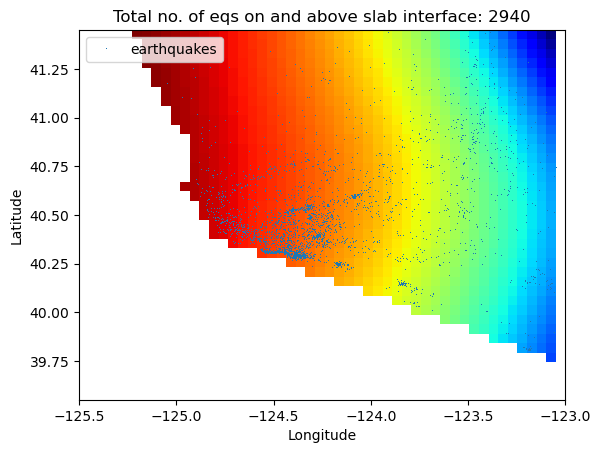

In [28]:
# intepolate slab depth to the earthquake locations
# and add the slab depth to the eq_df as a new column
eq_df['slab_depth'] = griddata(
    (slab2_df['lon'], slab2_df['lat']), 
    slab2_df['depth'], 
    (eq_df['longitude'], eq_df['latitude']), method='linear'
    )

# select earthquakes with slab_depth column is not NaN
eq_df_on_slab = eq_df[~np.isnan(eq_df['slab_depth'])] # ~ means not

# plot the earthquakes on the slab
eq_df_on_slab.plot(x='longitude', y='latitude', marker=',', linestyle='none', label='earthquakes', zorder=2)
# plot the slab
plt.imshow(dep_matrix, cmap='jet',
            extent=[np.min(lon), np.max(lon), np.min(lat), np.max(lat)]
            )

plt.title(f'Total no. of eqs on and above slab interface: {len(eq_df_on_slab)}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-125.5, -123)

plt.show()

# write the onslab_eq_df to a csv file
eq_df_on_slab.to_csv('../data/onslab_eq_2008_2022.csv', index=False)

In [29]:
# make slab depth positive because earthquake depth are also positive
eq_df_on_slab.loc[:, 'slab_depth'] = -eq_df_on_slab['slab_depth']

# get above slab earthquakes from eq_df_on_slab and remove index column
above_slab_eq_df = eq_df_on_slab[eq_df_on_slab['depth'] < eq_df_on_slab['slab_depth']]

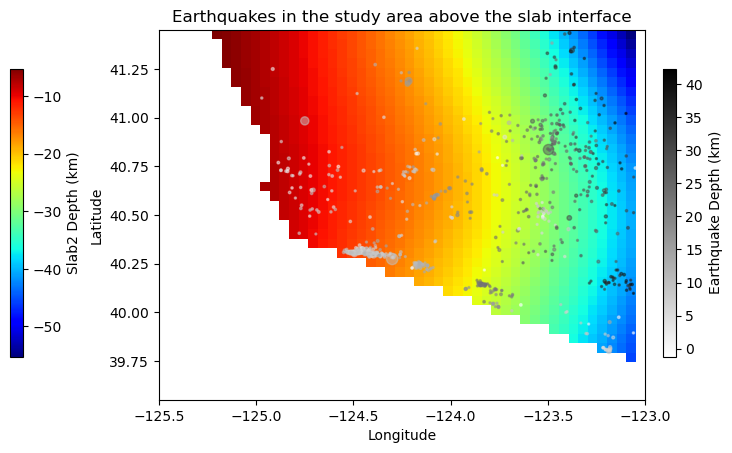

In [30]:
# plot the above_slab_eq_df and slab2_no_nan (as background using plt.imshow)
fig, ax = plt.subplots()

# plot the slab2 as background
ax.imshow(dep_matrix, cmap='jet', extent=[np.min(lon), np.max(lon), np.min(lat), np.max(lat)], label='slab2 depth')

# add colorbar for slab2 depth
sm1 = plt.cm.ScalarMappable(
    cmap='jet', 
    norm=plt.Normalize(vmin=slab2_no_nan['depth'].min(), vmax=slab2_no_nan['depth'].max())
    )
sm1.set_array([])
cax1 = fig.add_axes([-0.1, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
colorbar = fig.colorbar(sm1, cax=cax1, label='Slab2 Depth (km)')

# plot the earthquakes above the slab
ax.scatter(above_slab_eq_df['longitude'], above_slab_eq_df['latitude'], 
    marker='.', 
    s=np.exp(above_slab_eq_df['mag']), # make markersize proportional to the magnitude
    c=above_slab_eq_df['depth'], 
    cmap='binary', 
    alpha=0.5, 
    label='earthquake depth above the slab'
    )
ax.set_xlim(-125.5, -123)

# figure titles and others
ax.set_title('Earthquakes in the study area above the slab interface')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# add colorbar for earthquake depth
sm2 = plt.cm.ScalarMappable(
    cmap='binary', 
    norm=plt.Normalize(vmin=above_slab_eq_df['depth'].min(), vmax=above_slab_eq_df['depth'].max())
    )
sm2.set_array([])
cax2 = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # adjust position as needed
colorbar2 = fig.colorbar(sm2, cax=cax2, label='Earthquake Depth (km)')

plt.show()

# Check the result

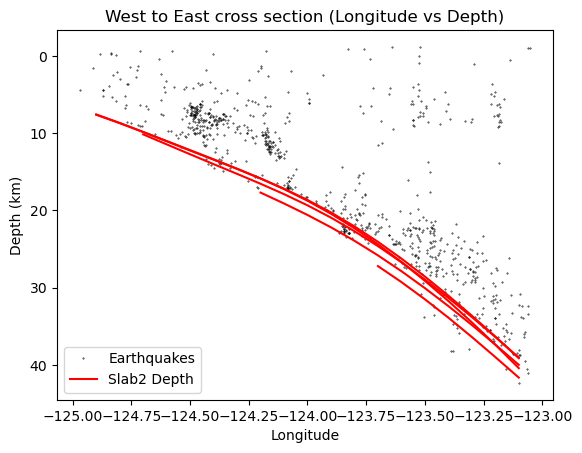

In [31]:
# plot a West to East cross section (Longitude vs Depth)
fig, ax = plt.subplots()
ax.plot(
    above_slab_eq_df['longitude'], 
    above_slab_eq_df['depth'], 
    '.', 
    color='black',
    markersize=0.75
    )

# plot the slab2 depth at equal interval latitudes from south to north
slab_dep = []
for i in range(0,5):   
    slab_lon = np.arange(-128, -123, 0.1)
    slab_lat = np.ones(len(slab_lon))*(40+i*0.2) # 40, 40.2, 40.4, 40.6, 40.8
    # interpolate the slab depth at the above latitudes and longitudes
    temp_slab_depth = griddata((slab2_no_nan['lon'], slab2_no_nan['lat']), slab2_no_nan['depth'], (slab_lon, slab_lat), method='linear')
    slab_dep.append(temp_slab_depth)

for i in range(0, 5):
    x = slab_lon
    y = -slab_dep[i]
    ax.plot(x, y, 'r-')
    

# invert the y axis
ax.invert_yaxis()

ax.set_xlabel('Longitude')
ax.set_ylabel('Depth (km)')
ax.set_title('West to East cross section (Longitude vs Depth)')
ax.legend(['Earthquakes', 'Slab2 Depth'])

plt.show()

In [32]:
# print min and max latitudes and longitudes of the above_slab_eq_df
print(np.min(above_slab_eq_df['latitude']), np.max(above_slab_eq_df['latitude']))
print(np.min(above_slab_eq_df['longitude']), np.max(above_slab_eq_df['longitude']))

39.8005 41.4356667
-124.9708333 -123.0501667


# Divide the study area into grids and select earthquakes within each grid
The purpose here is to select one event from each grid and determine their location accuracy and fault solution (focal mechanism).\
This way I will be able to see how the focal mechanism (a proxy for stress directions) changes from shallowere part of the subduction to the deeper part.

In [35]:
import numpy as np
import pandas as pd

# Define the area boundaries
min_lon, max_lon, min_lat, max_lat = -125, -123, 39.75, 41.5

# Define grid size
grid_size_lon = 0.5
grid_size_lat = 0.5

# Create grid coordinates
lon_grid = np.arange(min_lon, max_lon + grid_size_lon, grid_size_lon)
lat_grid = np.arange(min_lat, max_lat + grid_size_lat, grid_size_lat)

# Generate grid numbers
grid_numbers = 1
grid_codes = []
for i in range(len(lon_grid) - 1):
    for j in range(len(lat_grid) - 1):
        grid_codes.append(grid_numbers)
        grid_numbers += 1

# Convert grid codes to DataFrame
grid_df = pd.DataFrame({"grid_code": grid_codes})

# Add grid column to earthquake DataFrame
above_slab_eq_df.loc[:,'grid_code'] = 0

# Loop through each earthquake
for index, row in above_slab_eq_df.iterrows():
    lon = row['longitude']
    lat = row['latitude']

    # Find the corresponding grid cell
    i = int((lon - min_lon) // grid_size_lon)
    j = int((lat - min_lat) // grid_size_lat)

    # Assign the grid code to the earthquake
    above_slab_eq_df.loc[index, 'grid_code'] = grid_df.loc[i * (len(lat_grid) - 1) + j, 'grid_code']

# Sort the DataFrame by grid code
gridsort_above_slab_eq_df = above_slab_eq_df.copy()
gridsort_above_slab_eq_df.sort_values(by='grid_code', inplace=True)

# write the above_slab_eq_df to a csv file
gridsort_above_slab_eq_df.to_csv('../data/above_slab_eq_df.csv', index=False)

# view the earthquake DataFrame with grid codes
gridsort_above_slab_eq_df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,slab_depth,grid_code
8537,2020-05-03 13:12:55.150000+00:00,40.316500,-124.543333,10.040,3.16,ml,21.0,263.0,0.1561,0.19,...,earthquake,1.37,0.86,0.159,17.0,reviewed,nc,nc,12.455753,2
7596,2014-03-19 02:32:46.380000+00:00,40.307167,-124.527833,6.665,3.30,ml,28.0,240.0,0.1865,0.16,...,earthquake,0.76,0.55,0.135,20.0,reviewed,nc,nc,12.698703,2
17083,2019-02-11 10:42:51.920000+00:00,40.305833,-124.517000,10.460,2.41,md,10.0,263.0,0.1764,0.10,...,earthquake,0.63,0.83,0.132,17.0,reviewed,nc,nc,12.850160,2
7144,2011-11-11 16:12:12.970000+00:00,40.699833,-124.721000,1.264,2.59,md,40.0,258.0,0.3685,0.40,...,earthquake,1.77,1.64,0.169,35.0,reviewed,nc,nc,9.552765,2
6782,2009-07-16 10:56:05.870000+00:00,40.719333,-124.771667,6.287,2.69,md,44.0,246.0,0.4108,0.16,...,earthquake,1.01,1.60,0.126,44.0,reviewed,nc,nc,8.974137,2


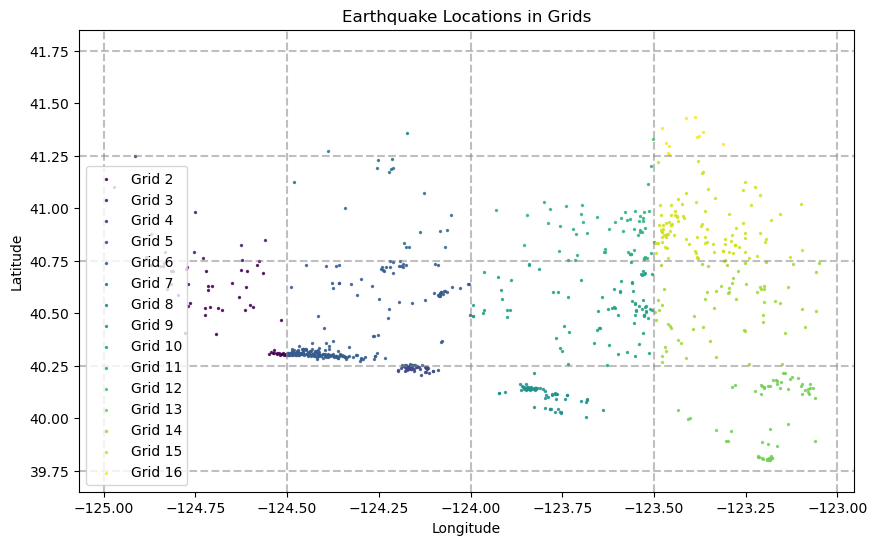

In [36]:
# Extract unique grid codes
unique_grid_codes = above_slab_eq_df['grid_code'].unique()

# Create a colormap for different grid codes
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(unique_grid_codes)))

# Plot the earthquake locations with different colors for each grid
fig, ax = plt.subplots(figsize=(10, 6))

for grid_code in unique_grid_codes:
    grid_earthquakes = above_slab_eq_df[above_slab_eq_df['grid_code'] == grid_code]
    ax.scatter(
        grid_earthquakes['longitude'],
        grid_earthquakes['latitude'],
        color=colors[np.where(unique_grid_codes == grid_code)[0][0]],
        s=2,
        alpha=0.8,
        label=f"Grid {grid_code}",
    )

# Add grid lines
for lon in lon_grid:
    ax.axvline(lon, color="gray", linestyle="--", alpha=0.5)

for lat in lat_grid:
    ax.axhline(lat, color="gray", linestyle="--", alpha=0.5)

# Add labels, title, and legend
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Earthquake Locations in Grids")
ax.legend()

# Show the plot
plt.show()